In [1]:
from stage1 import *

In [2]:
n_frames,n_atoms,n_mols = (0,0,0)
n_neigh = 15

In [3]:
model_stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [4]:

load = False
if load:
    graphs_cry_cpu = torch.load(f'./graphs/simple/crystal_neigh{n_neigh}.pt')
    graphs_melt_cpu = torch.load(f'./graphs/simple/melt_neigh{n_neigh}.pt')
else:
    # all_frames_cry = md.load_xtc("../simulation/para_crystal.xtc", top="../simulation/para_crystal.gro")
    all_frames_melt= md.load_xtc('../../xtc_files/50000eql2.xtc', top='../../xtc_files/conf.gro')
    # all_frames_melt = md.load_xtc("../simulation/para_melt.xtc", top="../simulation/para_melt.gro")
    # all_frames_cry.xyz = all_frames_cry.xyz*10
    all_frames_melt.xyz = all_frames_melt.xyz*10
    # all_frames_cry = all_frames_cry
    all_frames_melt = all_frames_melt[::50]
    global n_frames,n_atoms,n_mols 
    # n_frames = all_frames_cry.xyz.shape[0]
    # n_atoms = all_frames_cry.topology.residue(0).n_atoms
    # n_mols = all_frames_cry.topology.n_residues
    # condensed_crystal = condenseAllFrames(all_frames_cry)
#     condensed_crystal = condenseAllFrames_same_res_id(f,n_frames)
    condensed_melt = condenseAllFrames(all_frames_melt)
    # graphs_cry_cpu = get_graphs(condensed_crystal,"cry")
    graphs_melt_cpu = get_graphs(condensed_melt,"melt")
#     graphs_cry_cpu = pad(graphs_cry_cpu)
    graphs_melt_cpu = pad(graphs_melt_cpu)
    # torch.save(graphs_cry_cpu, f'./graphs/simple/crystal_neigh{n_neigh}.pt')
    torch.save(graphs_melt_cpu,f'./graphs/simple/melt_neigh{n_neigh}.pt')


  0%|          | 0/1001 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x45 and 15x9)

In [5]:
test_frame= md.load_xtc('../../xtc_files/50000eql2.xtc', top='../../xtc_files/conf.gro', frame=0)


In [6]:
cf = condenseFrame2(test_frame)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x45 and 15x9)

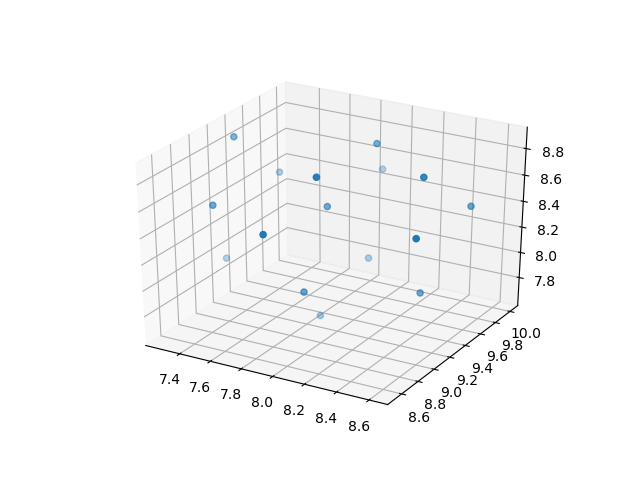

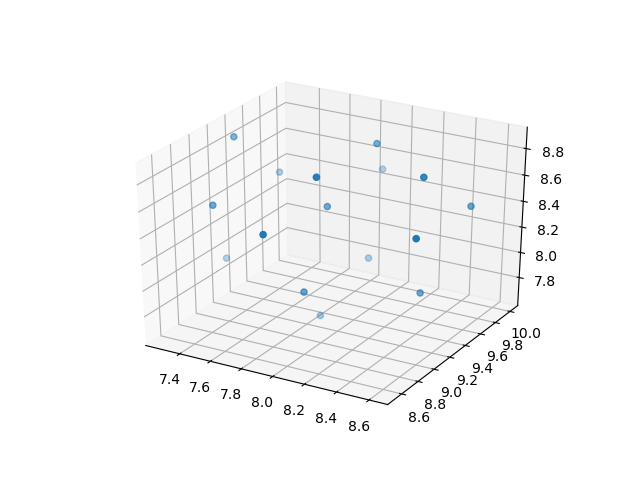

In [ ]:
# %matplotlib widget

g = get_graph(cf,10,n_neigh,"cry")
plot3D(g)

In [ ]:
graphs_cpu = graphs_cry_cpu + graphs_melt_cpu

In [ ]:
print(len(graphs_cry_cpu))
print(len(graphs_melt_cpu))

96192
87264
96192
87264


In [ ]:
np.random.shuffle(graphs_cpu)

## model

In [ ]:
from typing import Optional, Tuple 

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder_S2(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE_S2(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder_S2() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE_S2(GAE_S2):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [ ]:
class VariationalGCNEncoder_S2(torch.nn.Module):
    def __init__(self, in_channels, out_channels,batch_size,n_mols):
        
        self.embedding_size1 = 15
        self.embedding_size2 = 9
        self.linear_size1 = 100
        self.linear_size2 = 4
        
        self.batch_size = batch_size
        self.n_mols = n_mols
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        super().__init__()
        self.conv1 = GATConv(self.in_channels,self.embedding_size1,heads=3)
        self.head_transform1 = Linear(self.embedding_size1*3, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)
        
        self.conv2 = GCNConv(self.embedding_size1,self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)
        
        self.linear1 = Linear(self.embedding_size2, self.linear_size1)
        self.linear2 = Linear(self.linear_size1,self.linear_size2)
        
        self.transform = Linear(self.linear_size2*self.n_mols,self.out_channels)
        
        self.mu = Linear(self.out_channels, self.out_channels)
        self.logstd = Linear(self.out_channels, self.out_channels)

    def forward(self, x, edge_index):
        self.batch_size = x.shape[0]//self.n_mols
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)
        x = self.bn1(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        
        x = self.linear1(x)
        x = F.leaky_relu(x)

        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = x.reshape(self.batch_size,self.n_mols,-1)
        x = x.reshape(self.batch_size,-1)
        
        x = self.transform(x)
        x = F.leaky_relu(x)
        
        
        x,y,z = self.mu(x), self.logstd(x), edge_index
        return x,y,z


In [ ]:
class VariationalGCNDecoder_S2(torch.nn.Module):
    def __init__(self,in_channels,out_channels,batch_size,n_mols):
        self.embedding_size1 = 9
        self.embedding_size2 = 3
        self.embedding_size3 = 3
        self.linear_size1 = 512
        self.linear_size2 = 128
        self.batch_size = batch_size
        self.n_mols = n_mols
        self.in_channels = in_channels
        self.out_channels = out_channels

        super().__init__()
        self.inv_transform = Linear(self.in_channels,self.n_mols) 
        
        self.conv1 = GCNConv(1, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)

        self.conv2 = GCNConv(self.embedding_size1,self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)

        self.conv3 = GCNConv(self.embedding_size2,self.embedding_size3)

        self.linear1 = Linear(self.embedding_size3, self.linear_size1)
        self.linear2 = Linear(self.linear_size1, self.linear_size2)
        self.linear3 = Linear(self.linear_size2, self.out_channels)

    def forward(self, x, edge_index, sigmoid=True):
        self.batch_size = x.shape[0]//self.n_mols
        x = self.inv_transform(x)
        x = F.leaky_relu(x)

        x = x.reshape(x.shape[0]*x.shape[1],1)
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)        
        x = self.conv3(x,edge_index)
        
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.linear3(x)
        x = F.leaky_relu(x)

        
        return x, edge_index

In [ ]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 400
batch_size=64
test_train_split = 0.8
model_name = "LOCAL_Classifier.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [ ]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 183456/183456 [00:14<00:00, 12812.20it/s]



In [ ]:
graphs = graphs_device
total_graphs = len(graphs)

In [ ]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 183456
batch Size: 64
number of batches: 2866
Neighbours: 15
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(in_features=45, out_features=15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(in_features=9, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=4, bias=True)
    (transform): Linear(in_features=64, out_features=5, bias=True)
    (mu): Linear(in_features=5, out_features=5, bias=True)
    (logstd): Linear(in_features=5, out_features=5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(in_features=5, out_features=16, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(in_features=3, out_features=512, bias=True)
    (linear2): Linear(in_features=512, o

In [ ]:
split = int(test_train_split * total_graphs)

train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [ ]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        
        loss = MSE_loss(decoded_x, data.x)


        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [ ]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [ ]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./"+model_name)

Epoch: 001
	Train:	MSE Loss: 315.0337
	Test: 	MSE Loss: 146.6639
Epoch: 001
	Train:	MSE Loss: 315.0337
	Test: 	MSE Loss: 146.6639
Epoch: 002
	Train:	MSE Loss: 114.4365
	Test: 	MSE Loss: 100.4014
Epoch: 002
	Train:	MSE Loss: 114.4365
	Test: 	MSE Loss: 100.4014
Epoch: 003
	Train:	MSE Loss: 100.8897
	Test: 	MSE Loss: 95.2622
Epoch: 003
	Train:	MSE Loss: 100.8897
	Test: 	MSE Loss: 95.2622
Epoch: 004
	Train:	MSE Loss: 97.0924
	Test: 	MSE Loss: 92.2139
Epoch: 004
	Train:	MSE Loss: 97.0924
	Test: 	MSE Loss: 92.2139
Epoch: 005
	Train:	MSE Loss: 94.5800
	Test: 	MSE Loss: 90.8202
Epoch: 005
	Train:	MSE Loss: 94.5800
	Test: 	MSE Loss: 90.8202
Epoch: 006
	Train:	MSE Loss: 93.4332
	Test: 	MSE Loss: 89.4345
Epoch: 006
	Train:	MSE Loss: 93.4332
	Test: 	MSE Loss: 89.4345
Epoch: 007
	Train:	MSE Loss: 92.5855
	Test: 	MSE Loss: 89.0992
Epoch: 007
	Train:	MSE Loss: 92.5855
	Test: 	MSE Loss: 89.0992
Epoch: 008
	Train:	MSE Loss: 92.2137
	Test: 	MSE Loss: 88.7650
Epoch: 008
	Train:	MSE Loss: 92.2137
	Test: 	

Epoch: 066
	Train:	MSE Loss: 51.4923
	Test: 	MSE Loss: 48.6011
Epoch: 066
	Train:	MSE Loss: 51.4923
	Test: 	MSE Loss: 48.6011
Epoch: 067
	Train:	MSE Loss: 51.3589
	Test: 	MSE Loss: 48.2344
Epoch: 067
	Train:	MSE Loss: 51.3589
	Test: 	MSE Loss: 48.2344
Epoch: 068
	Train:	MSE Loss: 51.3204
	Test: 	MSE Loss: 50.5346
Epoch: 068
	Train:	MSE Loss: 51.3204
	Test: 	MSE Loss: 50.5346
Epoch: 069
	Train:	MSE Loss: 50.9726
	Test: 	MSE Loss: 47.7491
Epoch: 069
	Train:	MSE Loss: 50.9726
	Test: 	MSE Loss: 47.7491
Epoch: 070
	Train:	MSE Loss: 51.1884
	Test: 	MSE Loss: 48.2790
Epoch: 070
	Train:	MSE Loss: 51.1884
	Test: 	MSE Loss: 48.2790
Epoch: 071
	Train:	MSE Loss: 50.7300
	Test: 	MSE Loss: 48.5179
Epoch: 071
	Train:	MSE Loss: 50.7300
	Test: 	MSE Loss: 48.5179
Epoch: 072
	Train:	MSE Loss: 50.5424
	Test: 	MSE Loss: 48.5673
Epoch: 072
	Train:	MSE Loss: 50.5424
	Test: 	MSE Loss: 48.5673
Epoch: 073
	Train:	MSE Loss: 50.6394
	Test: 	MSE Loss: 47.3321
Epoch: 073
	Train:	MSE Loss: 50.6394
	Test: 	MSE Loss: 

Epoch: 131
	Train:	MSE Loss: 47.6759
	Test: 	MSE Loss: 46.3307
Epoch: 132
	Train:	MSE Loss: 47.8987
	Test: 	MSE Loss: 44.5105
Epoch: 132
	Train:	MSE Loss: 47.8987
	Test: 	MSE Loss: 44.5105
Epoch: 133
	Train:	MSE Loss: 47.5865
	Test: 	MSE Loss: 45.5020
Epoch: 133
	Train:	MSE Loss: 47.5865
	Test: 	MSE Loss: 45.5020
Epoch: 134
	Train:	MSE Loss: 47.6126
	Test: 	MSE Loss: 44.6274
Epoch: 134
	Train:	MSE Loss: 47.6126
	Test: 	MSE Loss: 44.6274
Epoch: 135
	Train:	MSE Loss: 47.9881
	Test: 	MSE Loss: 45.1131
Epoch: 135
	Train:	MSE Loss: 47.9881
	Test: 	MSE Loss: 45.1131
Epoch: 136
	Train:	MSE Loss: 48.0310
	Test: 	MSE Loss: 45.8810
Epoch: 136
	Train:	MSE Loss: 48.0310
	Test: 	MSE Loss: 45.8810
Epoch: 137
	Train:	MSE Loss: 48.0896
	Test: 	MSE Loss: 45.0904
Epoch: 137
	Train:	MSE Loss: 48.0896
	Test: 	MSE Loss: 45.0904
Epoch: 138
	Train:	MSE Loss: 47.4442
	Test: 	MSE Loss: 44.5502
Epoch: 138
	Train:	MSE Loss: 47.4442
	Test: 	MSE Loss: 44.5502
Epoch: 139
	Train:	MSE Loss: 47.5170
	Test: 	MSE Loss: 

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [ ]:
test_loader_melt = DataLoader(graphs_melt_cpu[::100], batch_size=1)
pred_melt=[]
for data in tqdm(test_loader_melt):
    model.eval()
    data = data.to(device)
    pred = model(data.x.float(),data.edge_index)
    pred_melt.append(pred.cpu().detach().numpy())
pred_melt = np.array(pred_melt)


In [ ]:
test_loader_cry = DataLoader(graphs_cry_cpu[::100], batch_size=1)
pred_cry=[]
for data in tqdm(test_loader_cry):
    model.eval()
    data = data.to(device)
    pred = model(data.x.float(),data.edge_index)
    pred_cry.append(pred.cpu().detach().numpy())

pred_cry = np.array(pred_cry)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = test_loader_melt
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()


In [ ]:
# %matplotlib widget

fig = plt.figure(figsize=(15,4))
data_melt = pred_melt
data_cry = pred_cry

plt.scatter(data_melt[:,0],data_melt[:,1],c="r",label="melt")
plt.scatter(data_cry[:,0],data_cry[:,1],c="b",label="crystal")
plt.legend()
plt.show()

In [ ]:
n_sample = 1000
n_class = 2
n_1 = 1000
n_2 = 1000